# Wk6_Notebook (Machine learning using Python)

In this notebook, I will introduce you to how machine learning can be performed using the Python ecosystem. More specifically, the following topics will be discussed:
- [A first application of classification predictive modeling](#Wk6_a)
- [Some improvements to the first application of classification predictive modeling](#Wk6_b)
- [Using statistical modeling for fraud detection](#Wk6_c)
- [Classification explanatory modeling](#Wk6_d)
- [Classification predictive modeling](#Wk6_e)

In [1]:
# Import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Earlier in this course, I have discused a number of standard data science (or analytics) tasks. In this notebook, I will focus exclusively on one of these tasks, namely classification. On the one hand, because this is a (supervised learning) task for which machine learning is widely used in practice. On the other hand, because the literature on machine learning is huge and I believe it is more informative to focus somewhat more extensively on (the basics of machine learning for) one task than to do so less extensively on a number of different data science (or analytics) tasks.

The main library for performing machine learning with the Python ecosystem is Scikit-learn. This library builds on the NumPy and SciPy libraries, as it (for example) works based on NumPy arrays. Although Scikit-learn offers many functionalities and machine learning algorithms, the basic steps used to build a model with this library are relatively simple.

## A first application of classification predictive modeling <a name="Wk6_a"></a>

The *iris* dataset, which is included with Scikit-learn, has a long, rich history in machine learning and statistics. Each row in this dataset describes one iris (which is a flower) in terms of the length and width of that flower's sepals and petals. There are four columns with measurements per iris, each of which is a length of one aspect of that iris. The final column, the classification target, is the particular species of that iris: 'setosa', 'versicolor', or 'virginica'.

In [2]:
# Import the data (1)

from sklearn.datasets import load_iris
iris_dataset = load_iris()
iris_dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
# Import the data (2)

df_iris = pd.DataFrame(iris_dataset.data, columns=iris_dataset.feature_names)
df_iris['target'] = iris_dataset.target
df_iris['target'] = df_iris['target'].astype('category')

### Exploring the dataset

#### Descriptive statistics

In [4]:
# Display dimensionality

df_iris.shape

(150, 5)

In [5]:
# Display the first 5 rows

df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
# Display general information

df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   target             150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


In [7]:
# Display summary statistics

df_iris.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843,0.828,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057,0.436,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758,1.765,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199,0.762,0.1,0.3,1.30,1.8,2.5


In [8]:
# Display class distribution

df_iris.groupby('target').size()

target
0    50
1    50
2    50
dtype: int64

#### Data visualizations

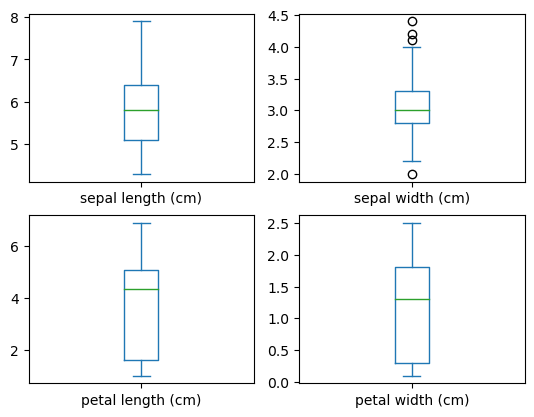

In [9]:
# Display boxplots

df_iris.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

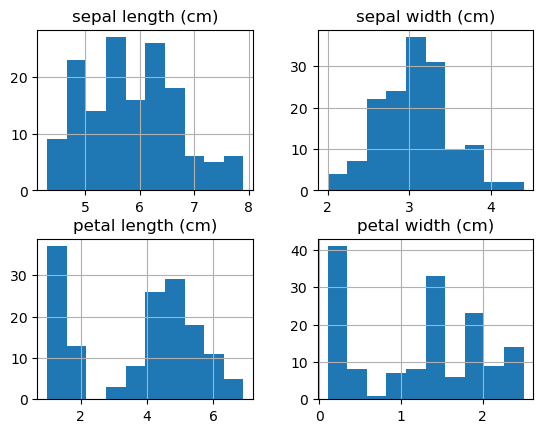

In [10]:
# Display histograms

df_iris.hist()
plt.show()

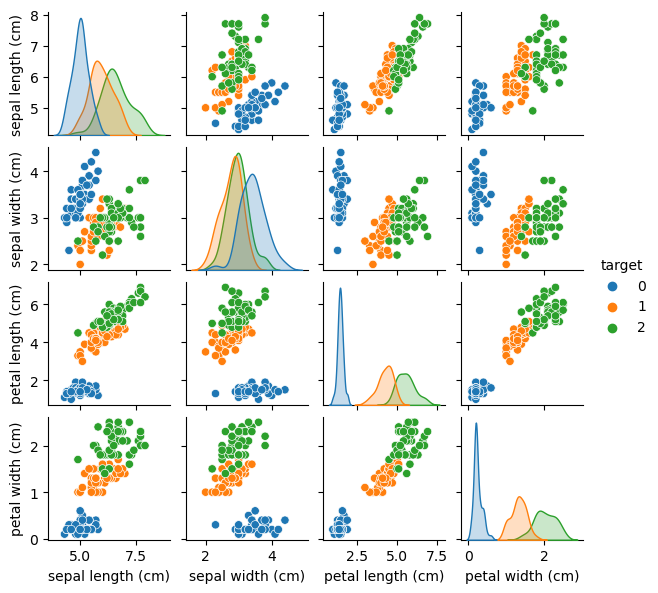

In [11]:
# Display pairplot

sns.pairplot(df_iris, hue='target', height=1.5);

### Building a *k*-NN classification model

The __*k*-nearest neighbors (*k*-NN)__ classification algorithm is a relatively simple machine learning algorithm that is widely used for building classification models. It is a similarity-based approach to machine learning, in that it is based on the idea that the best way to make predictions is to simply look at what has worked well in the past and predict the same thing again. As explained by Kelleher et al. (2020), the fundamental concepts required to build a system on the basis of this idea are a feature space representation of the instances in a dataset and a measure of similarity between instances. The training stage needed to build a nearest neighbors model is very simple and just involves storing all the training instances in memory. Next, in the prediction stage, when the model is used to make predictions for new query instances, the distance in the feature space between the query instance and each instance in memory is computed, and the prediction returned by the model is the target feature level of the instance that is nearest to the query in the feature space. The default distance metric used in nearest neighbors models is Euclidean distance.  
Kelleher et al. (2020) provide the following illustration of *k*-nearest neighbors:

<div>
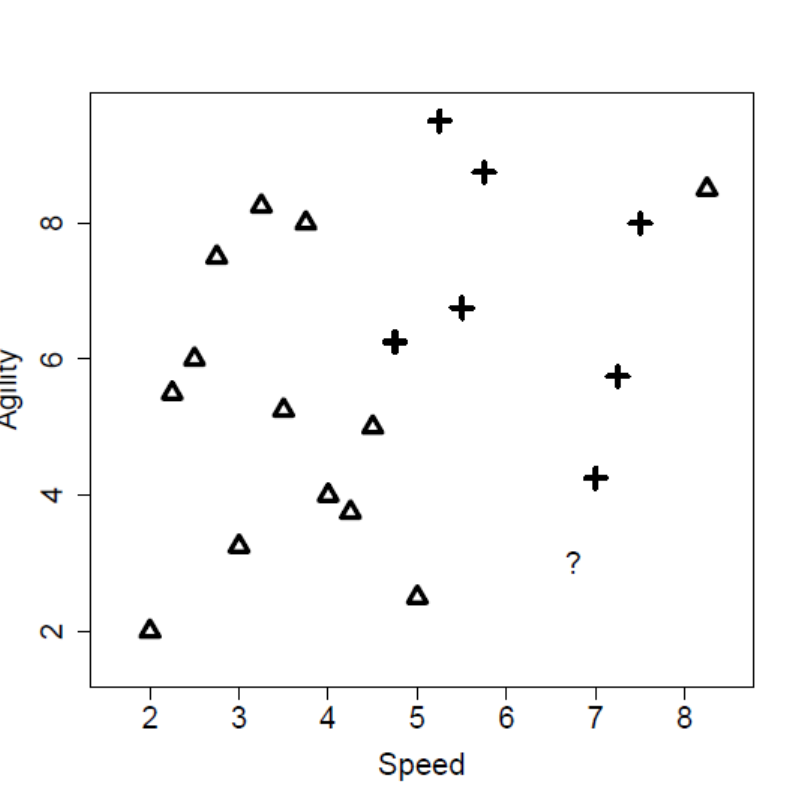
</div>

Before being able to build a model, we first have to split the dataset into a training set and a test set.

In [12]:
# Simple train-test split

array = df_iris.values
X = array[:, 0:4]
y = array[:, 4].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print("Train features shape: ", X_train.shape)
print("Test features shape: ", X_test.shape)

Train features shape:  (112, 4)
Test features shape:  (38, 4)


In Scikit-learn, all machine learning models are implemented in their own classes, which are called `Estimator` classes (Müller and Guido, 2017). The *k*-nearest neighbors classification algorithm is implemented in the `KNeighborsClassifier` class in the `neighbors` module. We therefore first always have to import the `Estimator` class(es) that we want to use. Next, we need to instantiate the class into an object. This is when we will set any parameters (also referred to as 'hyperparameters') of the model. For example, an important parameter of `KNeighborsClassifier` is the number of neighbors. To build the model on the training set, we then call the `fit` method of the object, which takes as arguments the NumPy array 'X_train' containing the training data and the NumPy array 'y_train' containing the corresponding training labels. Next, we can use the fit model to predict the labels in the test set. Finally, we can use one or more evaluation metrics to evaluate the quality of these predictions (and therefore of the model).

In [13]:
# Import the Estimator class(es)

from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Instantiate the class and set the parameters

knn = KNeighborsClassifier(n_neighbors=1)

In [15]:
# Build the model by calling the fit method

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [16]:
# Predict the labels in the test dataset

y_pred = knn.predict(X_test)
print("Test set predictions:\n", y_pred)

Test set predictions:
 [2 2 2 1 0 1 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 1 0 2 0 0 0 2 2 0 2 1 0 0 1 1 2
 0]


In [17]:
# Evaluate the model using the score method

print(f"Training set score: {knn.score(X_train, y_train):.2f}")
print(f"Test set score: {knn.score(X_test, y_test):.2f}")

Training set score: 1.00
Test set score: 0.89


If the quality of the model is considered to be satisfactory, it can then be used to make predictions on new data for which we might not know the correct labels.

In [18]:
# Use the model to make predictions

X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_New.shape:", X_new.shape)
prediction = int(knn.predict(X_new))
print("Prediction:", prediction)
print("Predicted target name:", iris_dataset['target_names'][prediction])

X_New.shape: (1, 4)
Prediction: 0
Predicted target name: setosa


As argued above, an important parameter of `KNeighborsClassifier` is the number of neighbors. To illustrate its importance, the following code shows the accuracy of the model for different choices concerning the number of neighbors.

In [19]:
# Model accuracy for different choices concerning the number of neighbors

for i in range(1, 11):
    # Import the algorithm's class
    from sklearn.neighbors import KNeighborsClassifier
    # Instantiate the class and set the parameters
    knn = KNeighborsClassifier(n_neighbors=i)
    # Build the model by calling the fit method
    knn.fit(X_train, y_train)
    # Evaluate the model using the score method
    print(f"Training set score: {knn.score(X_train, y_train):.2f}")
    print(f"Test set score: {knn.score(X_test, y_test):.2f}")

Training set score: 1.00
Test set score: 0.89
Training set score: 0.99
Test set score: 0.89
Training set score: 0.98
Test set score: 0.95
Training set score: 0.98
Test set score: 0.95
Training set score: 0.98
Test set score: 0.97
Training set score: 0.98
Test set score: 0.95
Training set score: 0.98
Test set score: 0.97
Training set score: 0.97
Test set score: 0.97
Training set score: 0.97
Test set score: 0.97
Training set score: 0.97
Test set score: 0.95


### Building a decision tree classification model

The __decision tree__ classification algorithm is another machine learning algorithm that is widely used for building classification models. It is an information-based approach to machine learning, in that it is based on the idea that an effective way to generate a prediction is to carry out a series of tests on the values of the descriptive features describing a query instance and use the answers to these tests to determine the prediction. As explained by Kelleher et al. (2020, p. 121-122), "a decision tree consists of a root node (or starting node), interior nodes, and leaf nodes (or terminating nodes) that are connected by branches. Each non-leaf node (root and interior) in the tree specifies a test to be carried out on a descriptive feature. [...] The process of using a decision tree to make a prediction for a query instance starts with testing the value of the descriptive feature at the root of the tree. The result of this test determines which of the root node's children the process should then descend to. These two steps of testing the value of a descriptive feature and descending a level in the tree are repeated until the process comes to a leaf node at which a prediction can be made."  
Kelleher et al. (2020) provide the following illustration of using a decision tree to analyze an email spam prediction dataset:

| ID | Suspicious Words | Unknown Sender | Contains Image | Class |
| --- | --- | --- | --- | --- |
| 376 | true | false | true | spam |
| 489 | true | true | false | spam |
| 541 | true | true | false | spam |
| 693 | false | true | true | ham |
| 782 | false | false | false | ham |
| 976 | false | false | false | ham |


<div>
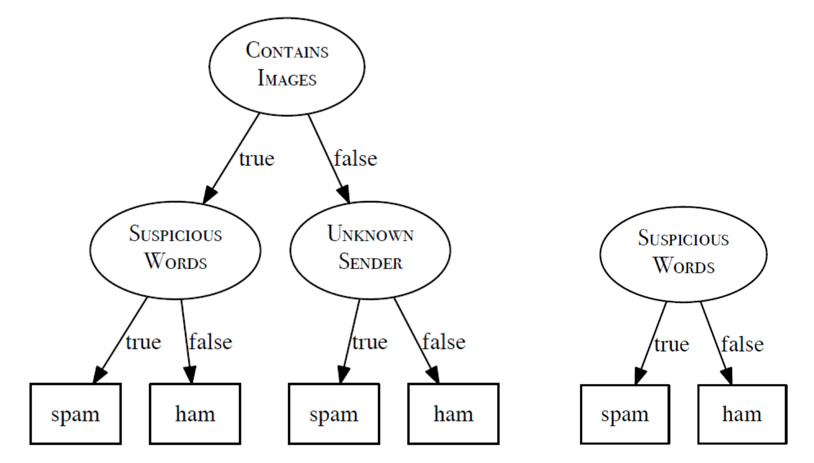
</div>

In [20]:
# Import the Estimator class(es)

from sklearn.tree import DecisionTreeClassifier

In [21]:
# Instantiate the class and set the parameters

clf = DecisionTreeClassifier(max_depth=3)

In [22]:
# Build the model by calling the fit method

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [23]:
# Predict the labels in the test dataset

y_pred = clf.predict(X_test)
print("Test set predictions:\n", y_pred)

Test set predictions:
 [1 2 2 1 0 1 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 1 0 2 0 0 0 2 2 0 2 1 0 0 1 1 2
 0]


In [24]:
# Evaluate the model using the score method

print(f"Training set score: {clf.score(X_train, y_train):.2f}")
print(f"Test set score: {clf.score(X_test, y_test):.2f}")

Training set score: 0.98
Test set score: 0.92


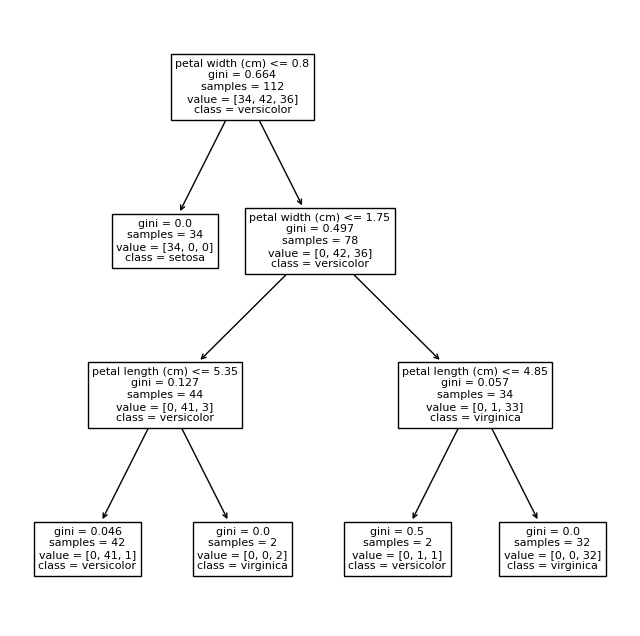

In [25]:
# Display the decision tree

from sklearn.tree import plot_tree

plt.figure(figsize=(8, 8))  # To resize the figure
plot_tree(clf, feature_names=iris_dataset.feature_names, class_names=iris_dataset.target_names);

In [26]:
# Use the model to make predictions

X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_New.shape:", X_new.shape)
prediction = int(clf.predict(X_new))
print("Prediction:", prediction)
print("Predicted target name:", iris_dataset['target_names'][prediction])

X_New.shape: (1, 4)
Prediction: 0
Predicted target name: setosa


### Building a logistic regression classification model

The __logistic regression__ classification algorithm is another machine learning algorithm that is widely used for building classification models. It is a variation of linear regression, and as such an error-based approach to machine learning, in that it performs a search for a set of parameters for a parameterized model that minimizes the total error across the predictions made by that model with respect to a set of training instances. As explained by Kelleher et al. (2020), to build a logistic regression model, we treshold the output of the basic linear regression model using the logistic function, which is given by:

$$logistic(x) = 1/(1\ +\ e^{-x})$$,

where x is a numeric value and e is Euler's number and is approximately equal to 2.7183. So, instead of the regression function simply being the dot product of the weights and the descriptive features, the dot product of weights and descriptive feature values is passed through the logistic function.  
Kelleher et al. (2020) provide the following plot of the logistic function for values of x in the range [-10, 10]:

<div>
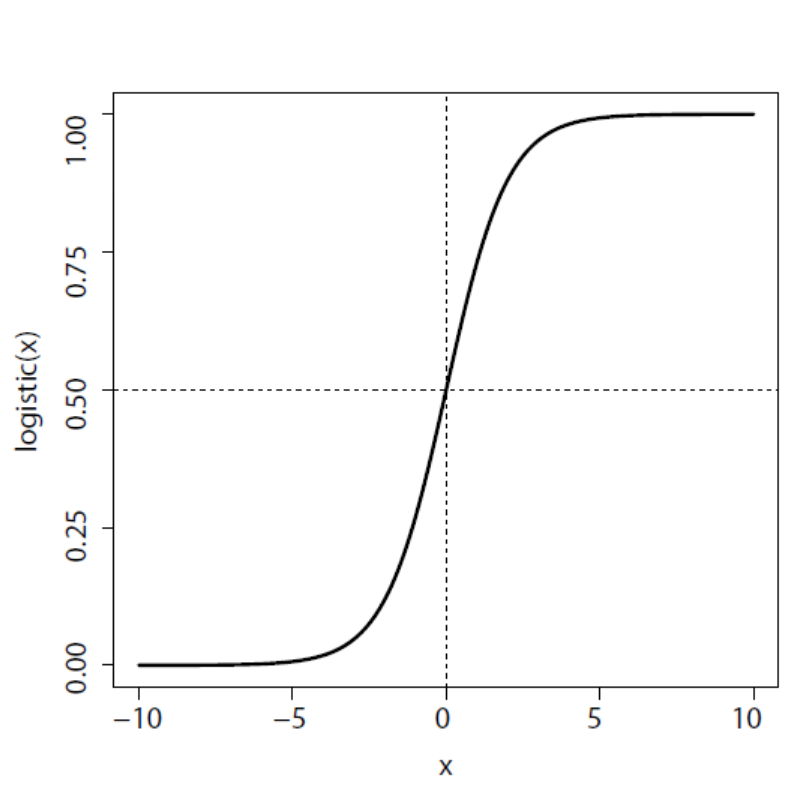
</div>

In [27]:
# Import the Estimator class(es)

from sklearn.linear_model import LogisticRegression

In [28]:
# Instantiate the class and set the parameters

logit = LogisticRegression(solver='liblinear', multi_class='ovr')

In [29]:
# Build the model by calling the fit method

logit.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [30]:
# Predict the labels in the test dataset

y_pred = logit.predict(X_test)
print("Test set predictions:\n", y_pred)

Test set predictions:
 [1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 1 0 2 0 0 0 2 2 0 2 2 0 0 1 1 2
 0]


In [31]:
# Evaluate the model using the score method

print(f"Training set score: {logit.score(X_train, y_train):.2f}")
print(f"Test set score: {logit.score(X_test, y_test):.2f}")

Training set score: 0.96
Test set score: 0.97


In [32]:
# Use the model to make predictions

X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_New.shape:", X_new.shape)
prediction = int(logit.predict(X_new))
print("Prediction:", prediction)
print("Predicted target name:", iris_dataset['target_names'][prediction])

X_New.shape: (1, 4)
Prediction: 0
Predicted target name: setosa


## Some improvements to the first application of classification predictive modeling <a name="Wk6_b"></a>

### *k*-fold cross-validation

Above, we used a simple train-test split to split the dataset into a training set and a test set. Two issues may arise when using this approach (Kelleher et al., 2020):
- It requires that we have enough data avaliable to make suitably large training and test sets. This is not always the case, and making any of these partitions too small can result in a poor evaluation.
- It may lead to a lucky split of the data that places the difficult instances into the training set and the easy ones into the test set. This will make the model appear more accurate than it will actually be when deployed.

A commonly used sampling method that attempts to address these issues is *k*-fold cross-validation. When this approach is used, the available data is divided into *k* equal-sized folds (or partitions), and *k* separate evaluation experiments are performed. Finally, the *k* sets of evaluation metrics are aggregated to give one overall set of evaluation metrics.  
Kelleher et al. (2020) provide the following illustration of *k*-fold cross-validation:

<div>
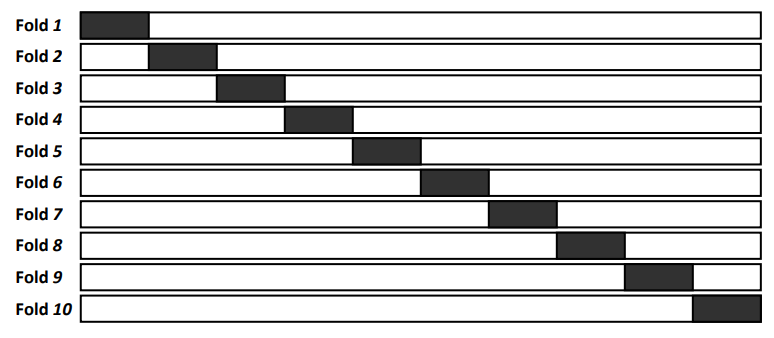
</div>

### Building multiple models

Above, we used one machine learning algorithm at a time to build a model. In practice, typically multiple machine learning algorithms are used to build multiple models, after which the best performing model is chosen and further fine-tuned.

In [33]:
# Using k-fold cross-validation and building multiple models

models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.954545 (0.060984)
KNN: 0.972727 (0.041660)
CART: 0.928030 (0.079111)


### Classification evaluation metrics

Evaluation metrics are used for at least two purposes: (1) to determine which of the models that we have built for a particular task is most suited to that task, and (2) to estimate how the model will perform when deployed. Above, we have evaluated the results of the analysis based only on accuracy. However, there are other evaluation metrics that provide additional insights, and there are circumstances where accuracy does not provide a good estimate of how well an algorithm performs. This is especially the case when one of the conditions is relatively rare, a situation that is referred to as an __imbalanced dataset__. For example, suppose that you develop a model that predicts fraud and that fraud occurs in about 1% of the cases. If in that situation, you would use a very simple model that predicts every new instance to not be fraud, then you would be correct 99% of the time (i.e., accuracy would be 0.99). However, despite this very high accuracy score, this model would not be very useful, as you would not predict any fraud case correctly. Let's therefore look at some of the most widely used classification evaluation metrics.

The simplest evaluation metrics that we can use to assess how well a classification model performs is __classification accuracy__, which is equal to the number of correct predictions divided by the total number of predictions, or its opposite, __misclassification rate__, which is equal to the number of incorrect predictions divided by the total number of predictions. The __confusion matrix__ is the basis for calculating these and many other evaluation metrics:

| Target | Positive Prediction | Negative Prediction |
| --- | --- | --- |
| __Positive Class__ | True Positive (TP) | False Negative (FN) |
| __Negative Class__ | False Positive (FP) | True Negative (TN) |

Using the confusion matrix, __classification accuracy__ is defined as:

$$classification\ accuracy = (TP + TN)\ /\ (TP + TN + FP + FN)$$

And the __misclassification rate__ is defined as:

$$misclassification\ rate = (FP + FN)\ /\ (TP + TN + FP + FN)$$

Some other confusion matrix-based evaluation metrics are __true positive rate (TPR)__ (or __sensitivity__), __true negative rate (TNR)__ (or __specificity__), __false negative rate (FNR)__ and __false positive rate__, which convert raw numbers from the confusion matrix into percentages. These metrics are defined as:

$$true\ positive\ rate\ (or\ sensitivity) = TP\ /\ (TP + FN)$$

$$true\ negative\ rate\ (or\ specificity) = TN\ /\ (TN + FP)$$

$$false\ negative\ rate = FN\ /\ (TP + FN)$$

$$false\ positive\ rate = FP\ /\ (TN + FP)$$

And some other frequently used confusion matrix-based evaluation metrics are precision, recall and the $F_{1}$ measure. __Precision__ tells us how confident we can be that an instance predicted to have the positive target level actually has the positive target level, whereas __recall__ is equivalent to true positive rate (TPR), and tells us how confident we can be that all the instances with the positive target level have been found by the model. Precision is defined as:

$$precision = TP\ /\ (TP + FP)$$

Precision and recall can be collapsed into a single evaluation metric known as the __$F_{1}$ measure__, which is defined as:

$$F_{1}\ measure = 2\ x\ (precision\ x\ recall)/(precision\ +\ recall)$$

In [34]:
# Display some confusion matrix-based evaluation metrics

predictions = knn.predict(X_test)

print(accuracy_score(y_test, predictions), '\n')
print(confusion_matrix(y_test, predictions), '\n')
print(classification_report(y_test, predictions))

0.9473684210526315 

[[16  0  0]
 [ 0  8  0]
 [ 0  2 12]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.80      1.00      0.89         8
           2       1.00      0.86      0.92        14

    accuracy                           0.95        38
   macro avg       0.93      0.95      0.94        38
weighted avg       0.96      0.95      0.95        38



## Using statistical modeling for fraud detection <a name="Wk6_c"></a>

Earlier in this course, I discussed some aspects of a paper by Bao et al. (2020, *JAR*), in which machine learning is used to develop a predictive fraud detection model. The materials of this paper are publicly available via https://github.com/JarFraud/FraudDetection. Here, Bao et al., among others, explain that:

"The file "uscecchini28.csv" is our final dataset which contains the fraud labels and feature variables. The variable name of our fraud label is "misstate" (1 denotes fraud, and 0 denotes non-fraud). The variable names of the 28 raw financial data items are: act, ap, at, ceq, che, cogs, csho, dlc, dltis, dltt, dp, ib, invt, ivao, ivst, lct, lt, ni, ppegt, pstk, re, rect, sale, sstk, txp, txt, xint, prcc_f. The variable names of the 14 financial ratios are: dch_wc, ch_rsst, dch_rec, dch_inv, soft_assets, ch_cs, ch_cm, ch_roa, issue, bm, dpi, reoa, EBIT, ch_fcf. The variable new_p_aaer is used for identifying serial frauds as described in Section 3.3 (see the code in “RUSBoost28.m” for more details)."

The description of the 28 raw accounting variables is as follows:

- act -- Current Assets, Total
- ap -- Account Payable, Trade
- at -- Assets, Total
- ceq - -Common/Ordinary Equity, Total
- che -- Cash and Short-Term Investments
- cogs -- Cost of Goods Sold
- csho -- Common Shares Outstanding
- dlc -- Debt in Current Liabilities, Total
- dltis -- Long-Term Debt Issuance
- dltt -- Long-Term Debt, Total
- dp -- Depreciation and Amortization
- ib -- Income Before Extraordinary Items
- invt -- Inventories, Total
- ivao -- Investment and Advances, Other
- ivst -- Short-Term Investments, Total
- lct -- Current Liabilities, Total
- lt -- Liabilities, Total
- ni -- Net Income (Loss)
- ppegt -- Property, Plant and Equipment, Total
- pstk -- Preferred/Preference Stock (Capital), Total
- re -- Retained Earnings
- rect -- Receivables, Total
- sale -- Sales/Turnover (Net)
- sstk -- Sale of Common and Preferred Stock
- txp -- Income Taxes Payable
- txt -- Income Taxes, Total
- xint -- Interest and Related Expense, Total
- prcc_f -- Price Close, Annual, Fiscal

The description of the 14 financial ratio variables is as follows:

- dch_wc -- WC accruals
- ch_rsst -- RSST accruals
- dch_rec -- Change in receivables
- dch_inv -- Change in inventory
- soft_assets -- % Soft assets
- dpi -- Depreciation index
- ch_cs -- Change in cash sales
- ch_cm -- Change in cash margin
- ch_roa -- Change in return on assets
- ch_fcf -- Change in free cash flows
- reoa -- Retained earnings over total assets
- EBIT -- Earnings before interest and taxes over total assets
- issue -- Actual issuance
- bm -- Book-to-market

In [35]:
# Import the data

df_bao = pd.read_csv('data/uscecchini28.csv')
df_bao

,fyear,gvkey,sich,insbnk,understatement,option,p_aaer,new_p_aaer,misstate,act,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
0,1990,1009,3460.0,0,0,0,NaN,NaN,0,10.047,...,0.312448,0.095082,0.082631,-0.019761,1,0.413170,0.873555,0.167620,0.161961,-0.042140
1,1990,1011,4841.0,0,0,0,NaN,NaN,0,1.247,...,0.315904,0.188832,-0.211389,-0.117832,1,0.157887,0.745139,-0.428957,-0.157888,0.100228
2,1990,1017,3812.0,0,0,0,NaN,NaN,0,55.040,...,0.605342,0.097551,-0.105780,0.091206,1,2.231337,1.015131,0.394768,0.063681,0.066348
3,1990,1021,3861.0,0,0,0,NaN,NaN,0,24.684,...,0.793068,-0.005725,-0.249704,0.017545,1,1.043582,1.026261,0.094822,0.088347,-0.017358
4,1990,1028,7385.0,0,0,0,NaN,NaN,0,17.325,...,0.869182,-0.231536,-1.674893,-0.466667,0,-1.602508,0.598443,-0.942379,-0.700821,0.130349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146040,2014,314866,8200.0,0,0,0,NaN,NaN,0,262.600,...,0.751944,0.560406,0.127217,-0.050591,1,0.103693,0.829680,-0.327178,-0.008179,-0.261606
146041,2014,315318,2890.0,0,0,0,NaN,NaN,0,1578.400,...,0.742781,-0.118178,0.031360,0.095355,1,0.581796,0.743084,-0.077826,0.000461,-0.296702
146042,2014,316056,3420.0,0,0,0,NaN,NaN,0,973.800,...,0.751129,0.004207,-0.037925,0.072050,1,-0.000903,1.063878,-0.002877,0.153133,0.065569
146043,2014,317260,4412.0,0,0,0,NaN,NaN,0,51.743,...,0.018001,NaN,NaN,NaN,1,1.109467,NaN,0.000000,0.028804,NaN


### Explore the dataset

In [36]:
# Display the column names

print(df_bao.columns.tolist())

['fyear', 'gvkey', 'sich', 'insbnk', 'understatement', 'option', 'p_aaer', 'new_p_aaer', 'misstate', 'act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk', 'txp', 'txt', 'xint', 'prcc_f', 'dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf']


In [37]:
# Display general information

df_bao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146045 entries, 0 to 146044
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fyear           146045 non-null  int64  
 1   gvkey           146045 non-null  int64  
 2   sich            132516 non-null  float64
 3   insbnk          146045 non-null  int64  
 4   understatement  146045 non-null  int64  
 5   option          146045 non-null  int64  
 6   p_aaer          964 non-null     float64
 7   new_p_aaer      964 non-null     float64
 8   misstate        146045 non-null  int64  
 9   act             146045 non-null  float64
 10  ap              146045 non-null  float64
 11  at              146045 non-null  float64
 12  ceq             146045 non-null  float64
 13  che             146045 non-null  float64
 14  cogs            146045 non-null  float64
 15  csho            146045 non-null  float64
 16  dlc             146045 non-null  float64
 17  dltis     

In [38]:
# Display summary statistics

df_bao.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
fyear,146045.0,2002.012,6.960,1990.000,1996.000,2002.000,2008.000,2014.000
gvkey,146045.0,54243.436,59937.456,1004.000,10658.000,25088.000,66586.000,317264.000
sich,132516.0,4471.198,2084.283,100.000,2860.000,3826.000,5812.000,9997.000
insbnk,146045.0,0.030,0.170,0.000,0.000,0.000,0.000,1.000
understatement,146045.0,0.000,0.013,0.000,0.000,0.000,0.000,1.000
option,146045.0,0.001,0.030,0.000,0.000,0.000,0.000,1.000
p_aaer,964.0,2503.840,912.093,371.000,1803.000,2620.500,3180.000,3996.000
new_p_aaer,964.0,25039.449,9120.951,3711.000,18031.000,26206.000,31801.000,39962.000
misstate,146045.0,0.007,0.081,0.000,0.000,0.000,0.000,1.000
act,146045.0,737.848,3744.542,-0.254,8.277,47.501,249.832,152629.000


In [39]:
# Display observed counts for the 'misstate' variable

df_bao.misstate.value_counts()

0    145081
1       964
Name: misstate, dtype: int64

In [40]:
# Display proportions for the 'misstate' variable

df_bao.misstate.value_counts(normalize=True)

0    0.993399
1    0.006601
Name: misstate, dtype: float64

In [41]:
# Display observed counts for the 'misstate' variable per fiscal year

df_bao.groupby('fyear')['misstate'].value_counts().unstack()

misstate,0,1
fyear,,
1990,4567,15
1991,4686,27
1992,4944,26
1993,5347,30
1994,5661,23
1995,6208,22
1996,6712,33
1997,6747,42
1998,6660,56


## Classification explanatory modeling <a name="Wk6_d"></a>

Explanatory modeling refers to the application of statistical models to data for testing (causal) hypotheses about theoretical constructs. When examining fraud detection, one would likely use logistic regression analysis to estimate a statistical model that predicts fraudulently misstating financial statement information based on a number of theory-based fraud determinants. Also, one would likely use all available observations to estimate this model.

Let's look at an example by analyzing to what extent the 14 ratios that are part of the Bao et al. (2020, *JAR*) dataset predict fraudulently misstating financial statement information.

In [42]:
# Select the necessary variables (columns) and drop all rows with missing values

df_logit = df_bao[['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf', 'misstate']].dropna()
df_logit

,dch_wc,ch_rsst,dch_rec,dch_inv,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf,misstate
0,0.069595,0.046043,0.041935,0.033034,0.312448,0.095082,0.082631,-0.019761,1,0.413170,0.873555,0.167620,0.161961,-0.042140,0
1,-0.065604,-0.240937,-0.006248,-0.026684,0.315904,0.188832,-0.211389,-0.117832,1,0.157887,0.745139,-0.428957,-0.157888,0.100228,0
2,0.092822,0.020143,0.002156,0.002746,0.605342,0.097551,-0.105780,0.091206,1,2.231337,1.015131,0.394768,0.063681,0.066348,0
3,0.014060,0.035120,0.035583,0.008332,0.793068,-0.005725,-0.249704,0.017545,1,1.043582,1.026261,0.094822,0.088347,-0.017358,0
4,-0.540503,-0.575325,-0.102153,-0.222022,0.869182,-0.231536,-1.674893,-0.466667,0,-1.602508,0.598443,-0.942379,-0.700821,0.130349,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146039,0.085366,-0.025508,0.000541,0.000000,0.015362,-1.718931,0.435251,0.009248,1,2.626149,0.820630,-0.180677,-0.009215,0.030761,0
146040,-0.010251,0.204761,0.011437,0.000000,0.751944,0.560406,0.127217,-0.050591,1,0.103693,0.829680,-0.327178,-0.008179,-0.261606,0
146041,0.063226,0.341147,0.054938,0.034174,0.742781,-0.118178,0.031360,0.095355,1,0.581796,0.743084,-0.077826,0.000461,-0.296702,0
146042,-0.011512,0.011762,-0.003103,0.023024,0.751129,0.004207,-0.037925,0.072050,1,-0.000903,1.063878,-0.002877,0.153133,0.065569,0


In [43]:
# Display observed counts for the 'misstate' variable

df_logit['misstate'].value_counts()

0    125574
1       909
Name: misstate, dtype: int64

In [44]:
# Display proportions for the 'misstate' variable

df_logit['misstate'].value_counts(normalize=True)

0    0.992813
1    0.007187
Name: misstate, dtype: float64

In [45]:
# Estimate the logistic regression model

logit1 = smf.logit(formula = 'misstate ~ dch_wc + ch_rsst + dch_rec + dch_inv + soft_assets + ch_cs + ch_cm \
+ ch_roa + issue + bm + dpi + reoa + EBIT + ch_fcf', data=df_logit).fit()
print(logit1.summary())

Optimization terminated successfully.
         Current function value: 0.040796
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:               misstate   No. Observations:               126483
Model:                          Logit   Df Residuals:                   126468
Method:                           MLE   Df Model:                           14
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                 0.04303
Time:                        14:26:36   Log-Likelihood:                -5160.1
converged:                       True   LL-Null:                       -5392.1
Covariance Type:            nonrobust   LLR p-value:                 3.716e-90
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.1554      0.222    -32.176      0.000      -7.591      -6.720
dch_wc         -0.9463   

Some interpretations:
- The improvement in model likelihood over a null model is about 4.3%.
- The average change in the log odds of fraudulently misstating financial statement information per unit change in the 'dch_wc' variable is -0.946, when the other independent variables are held constant, and this effect is statistically significant.
- The average change in the log odds of fraudulently misstating financial statement information per unit change in the 'ch_rsst' variable is 0.974, when the other independent variables are held constant, and this effect is statistically significant.
- ETC., ETC.

These interpretations in terms of log odds are valid, but not so intuitive. An alternative is to interpret the effects in terms of odds ratios. To convert the coefficients to odds ratios, one needs to take the exponential of these coefficients.

In [46]:
# Estimate the odds ratios

logit1_odds = pd.DataFrame(np.exp(logit1.params), columns= ['OR'])
logit1_odds['z-value']= logit1.pvalues
logit1_odds[['2.5%', '97.5%']] = np.exp(logit1.conf_int())

logit1_odds

,OR,z-value,2.5%,97.5%
Intercept,0.000781,3.796142e-227,0.000505,0.001207
dch_wc,0.388183,9.696032e-03,0.189505,0.795157
ch_rsst,2.649556,5.690590e-04,1.522241,4.611718
dch_rec,7.421588,1.574489e-05,2.987952,18.434022
dch_inv,3.535805,4.844479e-02,1.008665,12.394513
soft_assets,6.613821,7.662932e-37,4.938909,8.856739
ch_cs,1.059241,2.676975e-02,1.006645,1.114586
ch_cm,0.997615,8.704155e-01,0.969401,1.026650
ch_roa,0.605351,2.108016e-02,0.395157,0.927352
issue,3.381731,3.357598e-11,2.358924,4.848017


Some interpretations:
- The odds of fraudulently misstating financial statement information decreases by a factor of 0.388 (or 61.2%) for every unit increase in the 'dch_wc' variable, when the other independent variables are held constant.
- The odds of fraudulently misstating financial statement information increases by a factor of 2.650 (or 165.0%) for every unit increase in the 'ch_rsst' variable, when the other independent variables are held constant.
- ETC., ETC.

In [47]:
# The independent variables set

X = df_logit[['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', 'dpi', 'reoa', 'EBIT', 'ch_fcf']]

In [48]:
# The correlations among the independent variables

X.corr()

,dch_wc,ch_rsst,dch_rec,dch_inv,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
dch_wc,1.000000,0.477934,0.418172,0.397980,0.061291,0.033255,0.027064,0.238508,0.063915,0.118863,0.020184,0.216578,0.333898,-0.280634
ch_rsst,0.477934,1.000000,0.252002,0.202582,-0.019202,0.086773,0.024264,0.376031,0.086559,0.188880,0.119167,0.302159,0.465549,-0.673891
dch_rec,0.418172,0.252002,1.000000,0.314209,0.106841,0.133974,-0.041772,0.132897,0.096474,0.023011,0.064674,0.113445,0.153592,-0.181805
dch_inv,0.397980,0.202582,0.314209,1.000000,0.084051,0.121563,0.028699,0.072907,0.090514,0.034347,0.081091,0.098876,0.127827,-0.174292
soft_assets,0.061291,-0.019202,0.106841,0.084051,1.000000,-0.004138,0.017362,-0.017907,-0.005257,-0.047722,-0.064242,-0.000076,0.029137,0.023449
ch_cs,0.033255,0.086773,0.133974,0.121563,-0.004138,1.000000,-0.016008,0.078068,0.050216,-0.016017,-0.013912,0.026012,0.006547,-0.078935
ch_cm,0.027064,0.024264,-0.041772,0.028699,0.017362,-0.016008,1.000000,0.013616,0.001497,0.006326,-0.010434,0.027878,0.042274,-0.011897
ch_roa,0.238508,0.376031,0.132897,0.072907,-0.017907,0.078068,0.013616,1.000000,0.002941,0.039433,0.092178,0.141759,0.396825,0.191527
issue,0.063915,0.086559,0.096474,0.090514,-0.005257,0.050216,0.001497,0.002941,1.000000,-0.025029,0.003268,0.093213,0.045432,-0.109415
bm,0.118863,0.188880,0.023011,0.034347,-0.047722,-0.016017,0.006326,0.039433,-0.025029,1.000000,-0.002778,0.278780,0.222399,-0.194098


In [49]:
# The variance inflation factors (VIFs)

def vif(X):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    X = sm.add_constant(X)
    
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    return vif_data[1:].round(3)

vif(X)

,feature,VIF
1,dch_wc,1.669
2,ch_rsst,4.150
3,dch_rec,1.300
4,dch_inv,1.262
5,soft_assets,1.031
6,ch_cs,1.049
7,ch_cm,1.007
8,ch_roa,2.269
9,issue,1.031
10,bm,1.111


In [50]:
# Robustness analysis (check sensitivity for imbalanced classification)

ratios = ['dch_wc', 'ch_rsst', 'dch_rec', 'dch_inv', 'soft_assets', 'ch_cs', 'ch_cm', 'ch_roa', 'issue', 'bm', \
          'dpi', 'reoa', 'EBIT', 'ch_fcf']
df_1 = df_logit[df_logit['misstate'] == 1]
df_comb = pd.DataFrame(columns=ratios)

for i in range(100):
    df_0 = df_logit[df_logit['misstate'] == 0].sample(len(df_1), replace=True)
    df_01 = pd.concat([df_0, df_1])
    model = smf.logit(formula = 'misstate ~ dch_wc + ch_rsst + dch_rec + dch_inv + soft_assets + ch_cs + ch_cm \
    + ch_roa + issue + bm + dpi + reoa + EBIT + ch_fcf', data=df_01).fit()
#    print(model.summary())
    df_comb = df_comb.append({ratios[0]: model.params[1], ratios[1]: model.params[2],
                              ratios[2]: model.params[3], ratios[3]: model.params[4],
                              ratios[4]: model.params[5], ratios[5]: model.params[6],
                              ratios[6]: model.params[7], ratios[7]: model.params[8],
                              ratios[8]: model.params[9], ratios[9]: model.params[10],
                              ratios[10]: model.params[11], ratios[11]: model.params[12],
                              ratios[12]: model.params[13], ratios[13]: model.params[14]}, ignore_index=True)

#print(df_comb)

for var in ratios:
    print(f"{var:12} : mean = {df_comb[var].mean():6.3f} / CI = ({np.percentile(df_comb[var], 2.5):6.3f}, {np.percentile(df_comb[var], 97.5):6.3f})")

Optimization terminated successfully.
         Current function value: 0.620050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.617792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628901
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.624440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.623723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.626866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.624751
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.637174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.625449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614408
  

Optimization terminated successfully.
         Current function value: 0.620281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.629168
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628584
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.616052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628934
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.622281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.623436
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630567
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.623818
  

## Classification predictive modeling <a name="Wk6_e"></a>

Predictive modeling refers to the application of a statistical model or machine learning algorithm to data for the purpose of predicting new or future observations. When examining fraud detection, one would use one or more machine learning algorithms to train a prediction model (using a training dataset) that classifies observations as either fraudulently misstating financial statement information or not, and then test the generalizability of the model on unseen data (using a test dataset).

When I started working on this notebook, I hoped that it would be possible to completely replicate the study of Bao et al. (2020, *JAR*). They haven't used the Python ecosystem for their analyses, however, but have instead used Matlab. The main problem that Bao et al. face is the fact that they are working with a __heavily imbalanced dataset__, in which the minority class (i.e., fraudulent cases) is very small and the majority class (i.e., non-fraudulent cases) very large. Analyses of such a dataset require specialized approaches, which in the Python ecosystem are not available via the Scikit-learn library, but which are available via a related library (imbalanced-learn). The functionalities of this library are not completely consistent with those available via Matlab, however, making it (currently) impossible to completely replicate the analyses of Bao et al. with this library. Moreover, given the difficulty of such analyses, it would become too difficult for this course anyway. I will therefore finish this notebook by some explanations (without illustrations) of some of the methods used by Bao et al. (2020, *JAR*).

### Out-of-time sampling

Instead of using a simple train-test split or *k*-fold cross-validation, Bao et al. (2020, *JAR*) use a sampling method which is referred to as 'out-of-time sampling'. That is, there is a natural structure in their data that they can take advantage of to form their test set, where they can use data from one period to build their training set and data from another period to build their test set.  
Kelleher et al. (2020) provide the following illustration of out-of-time sampling:

<div>
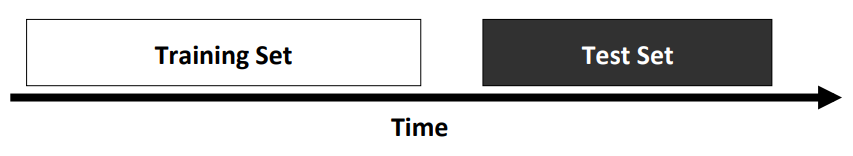
</div>

Two important considerations when using this sampling method are:
- The two different time periods from which the training and test sets are taken should be representative, because otherwise they may introduce a bias into the evaluation process.
- The time spans should be large enough to take into account any cyclical behavioral patterns.

### Ensemble learning models

Instead of using a machine learning algorithm to create a single model, Bao et al. (2020, *JAR*) use what is referred to as 'ensemble learning models'. That is, they generate a set of models and then make predictions by aggregating the outputs of these models. There are two defining characteristics of ensemble models (Kelleher et al., 2020):
1. They build multiple different models from the same dataset by inducing each model using a modified version of the dataset.
2. They make a prediction by aggregating the predictions of the different models in the ensemble.

Also, there are two standard approaches to creating ensembles (Kelleher et al., 2020):
1. Bagging - With bagging (or bootstrap aggregating), each model in the ensemble is trained on a random sample of the dataset where, importantly, each random sample is the same size as the dataset, and sampling with replacement is used. These random samples are known as bootstrap samples, and one model is induced from each bootstrap sample.
2. Boosting - With boosting, each new model added to an ensemble is biased to pay more attention to instances that previous models misclassified. This is done by incrementally adapting the dataset used to train the models.

Bao et al. (2020, *JAR*) use a boosting approach (__RUSBoost__) that is specifically developed for analyzing heavily imbalanced datasets.

### ROC-based evaluation metrics

The main evaluation metric that Bao et al. (2020, *JAR*) use is AUC (or Area Under the Curve), which is based on the Receiver Operating Characteristic curve (or ROC curve). Above, I showed how the true positive rate (TPR) and the true negative rate (TNR) can be calculated from a confusion matrix. However, these metrics are intrinsically tied to the threshold used to convert prediction scores into target levels. For example, the predicted target levels based on the logistic regression model are based on a prediction score threshold of 0.5. This threshold can be changed, however, which leads to different predicted target levels and a different confusion matrix, with different TPR and TNR values. For every possible value of the threshold, in the range [0, 1], there are corresponding TPR and TNR values. The ROC curve is drawn by plotting a point for the changing values for TPR and TNR as the threshold is varied from 0 to 1, and joining them.  
Kelleher et al. (2020) provide the following illustration of a ROC curve:

<div>
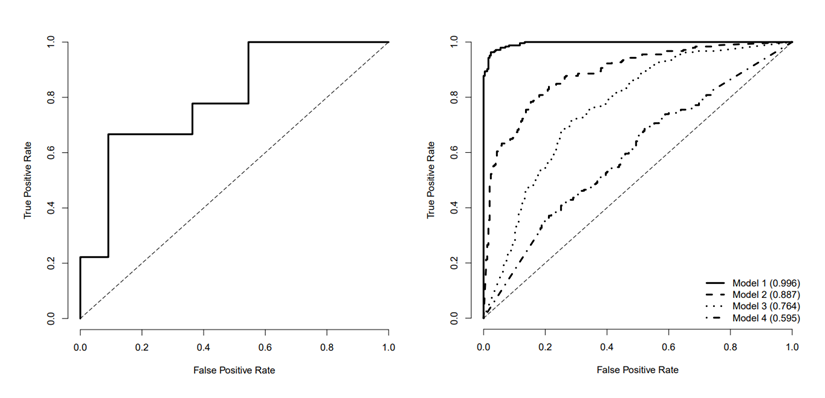
</div>

The __Area Under the Curve (AUC)__ measures the area underneath an ROC curve. It can take values in the range [0, 1], and larger values indicate better model performance.